In [2]:
!python evaluate.py --backbone ed5 --folds 1 --img-size 768
!python evaluate.py --backbone ed6 --folds 0 --img-size 768
!python evaluate.py --backbone ed7 --folds 0 --img-size 896
!python evaluate.py --backbone ed7 --folds 1 --img-size 896
!python evaluate.py --backbone ed7 --folds 2 --img-size 896

100%|█████████████████████████████████████████| 202/202 [07:42<00:00,  2.29s/it]
------------------------------
[Best box threshold]: 0.34
[Best nms threshold]: 0.48
[Best pp threshold]: 0.26
[AP]: 0.38210
100%|█████████████████████████████████████████| 188/188 [09:02<00:00,  2.89s/it]
------------------------------
[Best box threshold]: 0.32
[Best nms threshold]: 0.50
[Best pp threshold]: 0.26
[AP]: 0.35430
100%|█████████████████████████████████████████| 188/188 [11:55<00:00,  3.81s/it]
------------------------------
[Best box threshold]: 0.32
[Best nms threshold]: 0.48
[Best pp threshold]: 0.26
[AP]: 0.33659
100%|█████████████████████████████████████████| 202/202 [12:48<00:00,  3.81s/it]
------------------------------
[Best box threshold]: 0.32
[Best nms threshold]: 0.52
[Best pp threshold]: 0.26
[AP]: 0.39255
100%|█████████████████████████████████████████| 200/200 [12:46<00:00,  3.83s/it]
------------------------------
[Best box threshold]: 0.32
[Best nms threshold]: 0.56
[Best pp t

In [1]:
import os
import numpy as np
import pandas as pd
import gc
import cv2
import random
from PIL import Image
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from multiprocessing import Pool
from matplotlib import pyplot as plt
from ensemble_boxes import weighted_boxes_fusion
from utils import get_resolution, save_dict, load_dict, format_prediction_string, make_pseudo_dataframe, refine_checkpoint_in, refine_checkpoint_out

In [2]:
TEST_DIR = 'dataset/test'
TRAIN_DIR = 'dataset/train'
CHECKPOINT_DIR = 'checkpoints'
PSEUDO = True
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(8)]

In [3]:
df = 'dataset/train/'
image_file_list = [f for f in listdir(df) if isfile(join(df, f))]
image_ids = []
for id in image_file_list:
    image_ids.append(id.split(".")[0])

In [4]:
def visualize_result(TEST_DIR, output_dict):
    for image_id in list(['40_20','90_1','20_10','70_50','80_20','10_65','30_23','50_50','60_39']):
        img_path = '{}/{}.jpg'.format(TEST_DIR, image_id)
        image = Image.open(img_path)
        image = image.convert('RGB')
        image = np.array(image)

        boxes, scores, labels = output_dict[image_id]
        if len(boxes) > 0:
            boxes = boxes.astype(np.int32)

        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
        for idx, box in enumerate(boxes):
            plot_one_box([box[0], box[1], box[2], box[3]], image, color=colors[int(labels[idx])],
                     label=str(labels[idx]), line_thickness=True)
            # cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3)

        ax.set_axis_off()
        ax.imshow(image)

In [5]:
def plot_one_box(x, image, color=None, label=None, line_thickness=True):
    # Plots one bounding box on image img
    # tl = round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1  # line/font thickness
    # print(tl)
    tl = 1
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(image, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        # cv2.rectangle(image, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(image, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)


In [6]:
def run_wbf(image_ids, box_pred, score_pred, label_pred, NMS_THRESH, BOX_THRESH, PP_THRESH):
    output_dict = {}
    for image_id in image_ids:
        if image_id not in box_pred.keys(): continue
        boxes = box_pred[image_id]
        scores = score_pred[image_id]
        labels = label_pred[image_id]

        for idx, label in enumerate(labels):
            if 6.0 in label:
                print(image_id)

        boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=NMS_THRESH, skip_box_thr=BOX_THRESH)
        boxes = np.array(boxes)
        scores = np.array(scores)
        labels = np.array(labels)

        idxs = np.where(scores > PP_THRESH)[0]
        boxes = boxes[idxs]
        scores = scores[idxs]
        labels = labels[idxs]

        if len(boxes) > 0:
            height, width = 1080, 1920
            boxes[:, [0,2]] = (boxes[:, [0,2]]*width).clip(min=0, max=width-1)
            boxes[:, [1,3]] = (boxes[:, [1,3]]*height).clip(min=0, max=height-1)
        output_dict[image_id] = (boxes, scores, labels)
    return output_dict


In [7]:
def run_wbf_4preds(image_ids,
                   box_pred1, score_pred1, label_pred1,
                   box_pred2, score_pred2, label_pred2,
                    box_pred3, score_pred3, label_pred3,
                    box_pred4, score_pred4, label_pred4,
                   NMS_THRESH, BOX_THRESH, PP_THRESH):
    output_dict = {}
    for image_id in image_ids:
        if image_id not in box_pred1.keys(): continue
        boxes = box_pred1[image_id] + box_pred2[image_id] + box_pred3[image_id] + box_pred4[image_id]
        scores = score_pred1[image_id] + score_pred2[image_id] + score_pred3[image_id] + score_pred4[image_id]
        labels = label_pred1[image_id] + label_pred2[image_id] + label_pred3[image_id] + label_pred4[image_id]

        boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=NMS_THRESH, skip_box_thr=BOX_THRESH)
        boxes = np.array(boxes)
        scores = np.array(scores)

        idxs = np.where(scores > PP_THRESH)[0]
        boxes = boxes[idxs]
        scores = scores[idxs]

        if len(boxes) > 0:
            height, width = 1080, 1920
            boxes[:, [0, 2]] = (boxes[:, [0, 2]] * width).clip(min=0, max=width - 1)
            boxes[:, [1, 3]] = (boxes[:, [1, 3]] * height).clip(min=0, max=height - 1)
        output_dict[image_id] = (boxes, scores, labels)
    return output_dict

In [8]:
effdet_ed7_896_box_pred = load_dict('pkl_new/effdet_ed7_896_box_pred.pkl')
effdet_ed7_896_score_pred = load_dict('pkl_new/effdet_ed7_896_score_pred.pkl')
effdet_ed7_896_label_pred = load_dict('pkl_new/effdet_ed7_896_label_pred.pkl')

effdet_ed6_768_box_pred = load_dict('pkl_new/effdet_ed6_768_box_pred.pkl')
effdet_ed6_768_score_pred = load_dict('pkl_new/effdet_ed6_768_score_pred.pkl')
effdet_ed6_768_label_pred = load_dict('pkl_new/effdet_ed6_768_label_pred.pkl')

effdet_ed5_768_box_pred = load_dict('pkl_new/effdet_ed5_768_box_pred.pkl')
effdet_ed5_768_score_pred = load_dict('pkl_new/effdet_ed5_768_score_pred.pkl')
effdet_ed5_768_label_pred = load_dict('pkl_new/effdet_ed5_768_label_pred.pkl')

effdet_ed7_1024_box_pred = load_dict('pkl_new/effdet_ed7_1024_box_pred.pkl')
effdet_ed7_1024_score_pred = load_dict('pkl_new/effdet_ed7_1024_score_pred.pkl')
effdet_ed7_1024_label_pred = load_dict('pkl_new/effdet_ed7_1024_label_pred.pkl')

output_dict = run_wbf_4preds(image_ids, 
                         effdet_ed7_896_box_pred, effdet_ed7_896_score_pred, effdet_ed7_896_label_pred,
                         effdet_ed6_768_box_pred, effdet_ed6_768_score_pred, effdet_ed6_768_label_pred,
                         effdet_ed5_768_box_pred, effdet_ed5_768_score_pred, effdet_ed5_768_label_pred,
                         effdet_ed7_1024_box_pred, effdet_ed7_1024_score_pred, effdet_ed7_1024_label_pred, 
                         NMS_THRESH=0.50, BOX_THRESH=0.32, PP_THRESH=0.26)
    
    
del effdet_ed7_896_box_pred
del effdet_ed7_896_score_pred
del effdet_ed7_896_label_pred

del effdet_ed6_768_box_pred
del effdet_ed6_768_score_pred
del effdet_ed6_768_label_pred

del effdet_ed5_768_box_pred
del effdet_ed5_768_score_pred
del effdet_ed5_768_label_pred

del effdet_ed7_1024_box_pred
del effdet_ed7_1024_score_pred
del effdet_ed7_1024_label_pred

gc.collect()

0

TypeError: Can't convert object to 'str' for 'text'

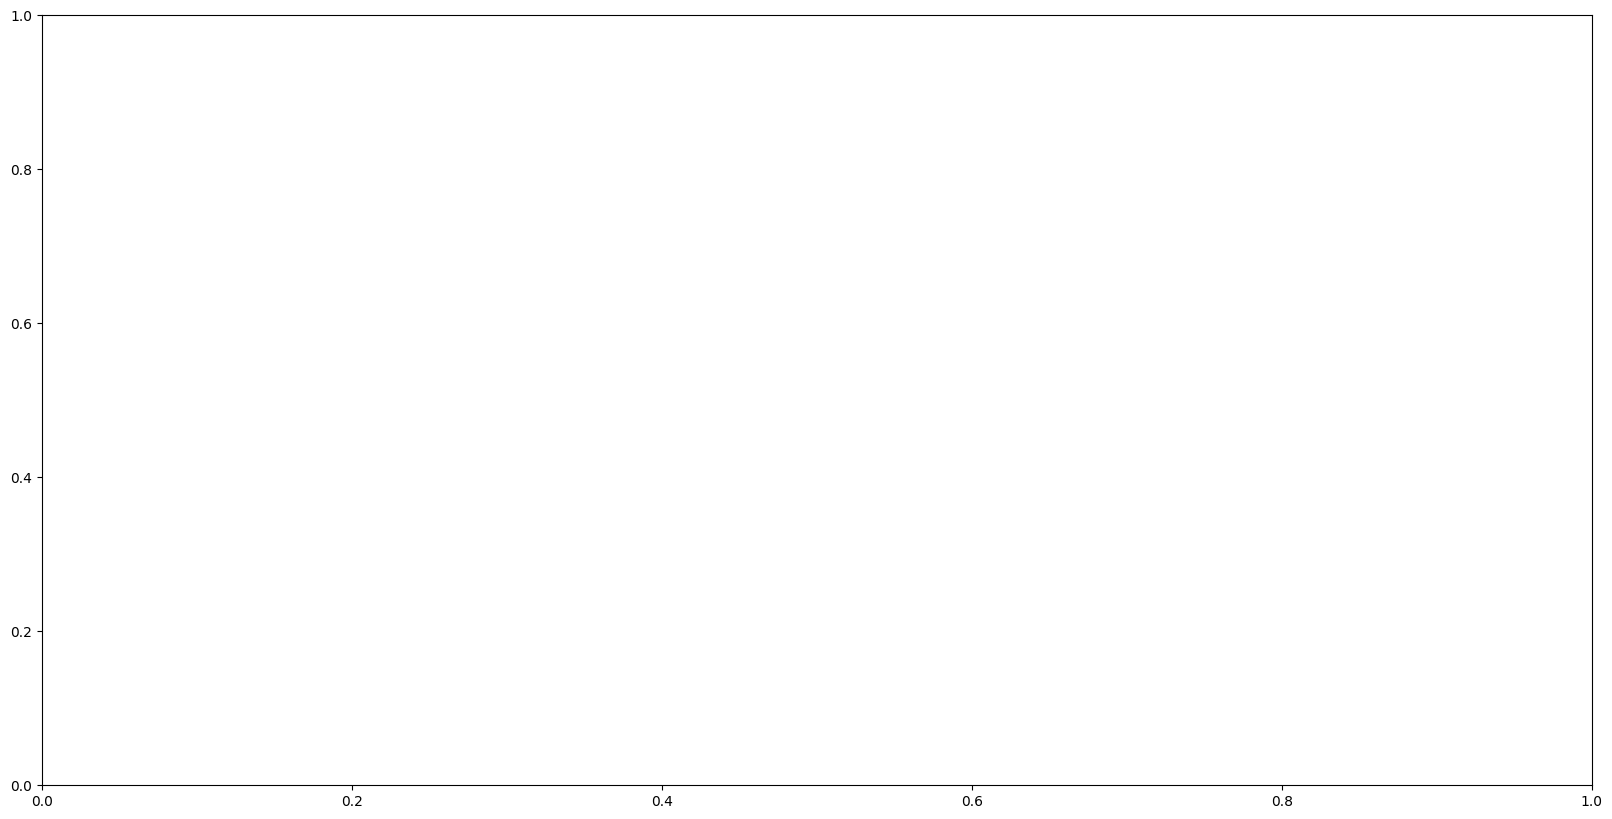

In [29]:
visualize_result(TEST_DIR, output_dict)

In [9]:
df = pd.read_csv('dataset/trainset_ai.csv')
PSEUDO_FOLD = 1
make_pseudo_dataframe(image_ids, output_dict, TEST_DIR, df, TRAIN_DIR, PSEUDO_FOLD)
del output_dict
gc.collect()

0

In [12]:
refine_checkpoint_out('checkpoints4/effdet_ed6_640_fold1_with_optimizer.pth', './effdet_ed6_640_fold1.pth')

In [13]:
box_pred = load_dict('effdet_ed6_640_box_pred.pkl')
score_pred = load_dict('effdet_ed6_640_score_pred.pkl')
label_pred = load_dict('effdet_ed6_640_label_pred.pkl')
output_dict = run_wbf(image_ids, box_pred, score_pred, label_pred, 
                      NMS_THRESH=0.50, BOX_THRESH=0.42, PP_THRESH=0.32)
del box_pred
del score_pred
del label_pred
gc.collect()

!rm -rf ./train.csv
!rm -rf ./valid.csv

In [14]:
df = pd.read_csv('dataset/trainset_ai.csv')   ### convert train.csv to image_id,fold,xmin,ymin,xmax,ymax,isbox,source
PSEUDO_FOLD = 1
make_pseudo_dataframe(image_ids, output_dict, TEST_DIR, df, TRAIN_DIR, PSEUDO_FOLD)
del output_dict
gc.collect()

0